### Imports

In [1059]:
from collections import defaultdict
import gymnasium as gym
import gym_simplegrid
from gym_simplegrid import envs
import matplotlib
import numpy as np
import os
# import shutil
# import torch
# import torchvision
import json
import copy
# from torch.utils.tensorboard import SummaryWriter
import scipy
import matplotlib.pyplot as plt
# from logger import Logger
from typing import Dict, List, Tuple
from collections import deque
import random


from plot import plot_metric, plot_avg_true_Q

from buffer import ReplayBuffer
from utils import Logger

### Define agents

In [1060]:
from agents import Agent, DoubleQ_Agent, VQ_Agent, Q_Agent, SARSA_Agent, ExpectedSARSA_Agent

# agent = Q_Agent(alpha=0.1, gamma=0.99, action_space=env.action_space, observation_space=env.observation_space, eps_start=0.2, eps_end=0.00, eps_dec=0.99999, random_init=True)
# def get_agent(config, env):
#     if config['algo_name'] == 'VQ-learning':
#         agent = VQ_Agent(alpha=config["alpha"], gamma=config["gamma"], action_space=env.action_space, observation_space=env.observation_space, eps_start=config["eps_start"], eps_end=config["eps_end"], eps_decay=config["eps_decay"], random_value_init=config["random_value_init"], alpha_v=config["alpha_v"], alpha_q=config["alpha_q"], importance_sampling=config["importance_sampling"], noisy_update = config['noisy_update'])
#     elif config['algo_name'] == 'Q-learning':
#         agent = Q_Agent(alpha=config["alpha"], gamma=config["gamma"], action_space=env.action_space, observation_space=env.observation_space, eps_start=config["eps_start"], eps_end=config["eps_end"], eps_decay=config["eps_decay"], random_value_init=config["random_value_init"], noisy_update = config['noisy_update'])
#     elif config['algo_name'] == 'DoubleQ-learning':
#         agent = DoubleQ_Agent(alpha=config["alpha"], gamma=config["gamma"], action_space=env.action_space, observation_space=env.observation_space, eps_start=config["eps_start"], eps_end=config["eps_end"], eps_decay=config["eps_decay"], random_value_init=config["random_value_init"], noisy_update = config['noisy_update'])
#     elif config['algo_name'] == 'SARSA':
#         agent = SARSA_Agent(alpha=config["alpha"], gamma=config["gamma"], action_space=env.action_space, observation_space=env.observation_space, eps_start=config["eps_start"], eps_end=config["eps_end"], eps_decay=config["eps_decay"], random_value_init=config["random_value_init"], noisy_update = config['noisy_update'])
#     elif config['algo_name'] == 'ExpectedSARSA':
#         agent = ExpectedSARSA_Agent(alpha=config["alpha"], gamma=config["gamma"], action_space=env.action_space, observation_space=env.observation_space, eps_start=config["eps_start"], eps_end=config["eps_end"], eps_decay=config["eps_decay"], random_value_init=config["random_value_init"], noisy_update = config['noisy_update'])
#     else:
#         raise ValueError(f"algo_name: {config['algo_name']} not supported")
#     return agent

def get_agent(config, env):
    if config['algo_name'] == 'VQ-learning':
        agent = VQ_Agent(action_space=env.action_space, observation_space=env.observation_space, **config)
    elif config['algo_name'] == 'Q-learning':
        agent = Q_Agent(action_space=env.action_space, observation_space=env.observation_space, **config)
    elif config['algo_name'] == 'DoubleQ-learning':
        agent = DoubleQ_Agent(action_space=env.action_space, observation_space=env.observation_space, **config)
    elif config['algo_name'] == 'SARSA':
        agent = SARSA_Agent(action_space=env.action_space, observation_space=env.observation_space, **config)
    elif config['algo_name'] == 'ExpectedSARSA':
        agent = ExpectedSARSA_Agent(action_space=env.action_space, observation_space=env.observation_space, **config)
    else:
        raise ValueError(f"algo_name: {config['algo_name']} not supported")
    return agent


### Define evaluate()

In [1061]:
def evaluate(eval_env, start_loc, goal_loc, agent, eval_total_steps, logger:Logger):
    eval_acc_reward = 0
    eval_step = 0
    eval_done = False
    eval_trunacted = False
    eval_obs, eval_info = eval_env.reset(options={'start_loc':start_loc, 'goal_loc':goal_loc})
    list_max_Q = []
    while eval_step < eval_total_steps:
        if eval_done or eval_trunacted:
            eval_obs, eval_info = eval_env.reset(options={'start_loc':start_loc, 'goal_loc':goal_loc})
        eval_action, action_info = agent.choose_action(eval_obs, greedy=True)
        eval_next_obs, eval_reward, eval_done, eval_trunacted, eval_info = eval_env.step(eval_action)
        list_max_Q.append(action_info['Q'])
        eval_step += 1
        # eval_acc_reward += eval_reward
        eval_obs = eval_next_obs
    return {"avg_max_Q": np.mean(list_max_Q)}

### Run the final learned policy, to compute the true Q value.

In [1062]:
import numpy as np

def run_policy(env, start_loc, goal_loc, agent, discount_factor):
    """
    Runs the policy derived from the Q-table and computes the actual discounted returns.
    
    Parameters:
    env - The environment (assumes OpenAI Gym-like environment)
    Q - The final Q-table
    discount_factor - The discount factor for future rewards
    max_steps - The maximum number of steps to run the policy

    Returns:
    returns - List of actual discounted returns for each visited state in the trajectory
    """
    state, info = env.reset(options={'start_loc':start_loc, 'goal_loc':goal_loc})
    done = False
    truncated = False
    total_return = 0.0
    steps = 0
    trajectory = []
    
    # Run the policy until the episode is done or max_steps is reached
    while not done and not truncated :
        # Choose the best action from the Q-table
        action, action_info = agent.choose_action(state, greedy=True)
        
        # Take the action in the environment
        next_state, reward, done, truncated, _ = env.step(action)
        
        # Append the current state and reward to the trajectory
        trajectory.append((state, next_state, reward))
        
        # Update state
        state = next_state
        steps += 1
    
    # Calculate the actual discounted returns
    returns = []
    G = 0
    for _, _, reward in reversed(trajectory):
        G = reward + discount_factor * G
        returns.append(G)
    
    # Reverse the returns list to correspond to the original trajectory order
    returns.reverse()
    
    return returns

# Example usage:
# Assuming you have a Q-table 'Q' and an environment 'env'
# import gym
# env = gym.make('your-environment-id')
# returns = run_policy(env, Q)
# print(returns) 

### Define run() 

In [1063]:
def run(env, start_loc, goal_loc, agent: Agent, config: dict, repeat_idx: int, total_steps: int, logger: Logger,):
    
    replay_buffer = ReplayBuffer(obs_dim=1, size=config['buffer_size'], batch_size=config['batch_size'])
        
    obs, info = env.reset(options={'start_loc':start_loc, 'goal_loc':goal_loc})
    # done = env.unwrapped.done
    done=False
    truncated = False
    episode_reward = 0
    episode_idx = 0
    learn_info_list = []
    trajectory = [obs]
    n_reset_buffer = 0
    n_learn = 0
    n_on_policy = 0
    running_avg = 1.0
    for step in range(total_steps):
        if done or truncated or step == total_steps-1:
            # print(f'repeat_idx: {repeat_idx} | step: {step} | episode reward:{episode_reward} | maxQ: {np.max(agent.Q)} | eps: {agent.eps}')
            data = {"repeat_idx": repeat_idx, "episode_idx": episode_idx, "step": step, "reward": episode_reward, "maxQ": np.max(agent.Q), "eps": agent.eps, "len_episode": len(trajectory)}
            data.update(info)
            #update done and truncated
            data.update({"done": done, "truncated": truncated})

            if done or truncated:
                if env.unwrapped.agent_xy == env.unwrapped.goals_xy[0]:
                    data.update({"reached_goal": 0})
                else:
                    data.update({"reached_goal": 1})
            logger.dump_episodic_data(data)

            obs, info = env.reset(options={'start_loc':start_loc, 'goal_loc':goal_loc})
            episode_reward = 0
            episode_idx += 1
            
            # print(f"repeat:{repeat_idx} trajectory: {trajectory} \n")
            # with open("results/temp.log", 'a') as f:
            #     f.write(f"repeat:{repeat_idx} step {step} done {done} truncated {truncated}trajectory: {trajectory}" + '\n')
            trajectory = [obs]
            
        if (step+1) % 100 == 0:    
            logger.dump({"repeat_idx": repeat_idx,"step": step})
            
        action, action_info = agent.choose_action(obs)
        agent.decay_explore()
        new_obs, reward, done, truncated, info = env.step(action)
        replay_buffer.store(obs, action, reward, new_obs, float(done), action_info['action_prob'])
        # logger.log(key='max_Q(s,a)', value=action_info['max_Q'])
        if len(replay_buffer) >= replay_buffer.batch_size:
            if config['algo_name'] == 'VQ-learning' and config["importance_sampling"]>0:
                trans = replay_buffer.sample_batch()
                if config['syncVQ']:
                    learn_info = agent.learn_syncVQ(trans['obs'], trans['acts'], trans['rews'], trans['next_obs'], trans['done'], prob_action=trans['prob_acts'])
                else:
                    learn_info = agent.learn(trans['obs'], trans['acts'], trans['rews'], trans['next_obs'], trans['done'], prob_action=trans['prob_acts'])
                n_learn += 1
                n_on_policy += 1
                # running_avg = (running_avg + np.mean(learn_info['mask_'])) / (n_on_policy + 1)
                # running_avg = running_avg * 0.5 + 0.5 * np.mean(learn_info['mask_'])
                # running_avg = np.mean(buf)
                running_avg = np.mean(learn_info['mask_'])
                if running_avg < config["importance_sampling"]:
                    replay_buffer.reset()
                    n_reset_buffer += 1
                    if config['syncVQ']:
                        agent.sync_VQ()
                    # running_avg = 0
                    # n_on_policy = 0
                else: 
                    pass
                    # print(f"np.mean(l_on_policy): {np.mean(l_on_policy)}")
                
                learn_info.update(
                    {
                        "n_learn": n_learn, 
                        "n_reset_buffer": n_reset_buffer, 
                        "n_on_policy": n_on_policy,
                        "running_avg": running_avg,
                    }
                    )
                learn_info_list.append(learn_info)
                for k, v in learn_info.items():
                    logger.log(key=k, value=v)
            else:
                trans = replay_buffer.sample_batch()
                learn_info = agent.learn(trans['obs'], trans['acts'], trans['rews'], trans['next_obs'], trans['done'], prob_action=trans['prob_acts'])
                learn_info_list.append(learn_info)
                for k, v in learn_info.items():
                    logger.log(key=k, value=v)
            if config['noisy_update'] > 0.0:
                agent.simulate_noisy_update()
        trajectory.append(new_obs)

        # [Evaluation]
        if step % config['eval_freq'] == 0:
            eval_dict = evaluate(eval_env=copy.deepcopy(env), start_loc=start_loc, goal_loc=goal_loc, agent=agent, eval_total_steps=config['eval_total_steps'], logger=logger)
            eval_dict.update({"step": step, "repeat_idx": repeat_idx})
            logger.dump_data(eval_dict, path=logger.eval_log_path) 

        episode_reward += reward
        obs = new_obs

    # print(f"n_reset_buffer: {n_reset_buffer}, n_learn: {n_learn}")    
    env.close()           



### Example of create a env and print somthing

In [1064]:
import numpy as np
obstacle_map = [
        "000",
        "000",
        "000",
    ]
start_loc = (1,1)
goal_loc = [(0,0), (2,2)]
map_name = "square"
map_str = np.asarray(obstacle_map, dtype='c')
print(map_str)
map_int = np.asarray(map_str, dtype=int)
print(map_int)

env = gym.make(
    'SimpleGrid-v0', 
    obstacle_map=obstacle_map, 
    # render_mode='human',
    max_episode_steps=300,
    render_mode=None,
)
print(env.observation_space.n)
obs, info = env.reset(options={'start_loc':start_loc, 'goal_loc':goal_loc})
print(obs)
print(np.zeros(1))
print(env._max_episode_steps)

[[b'0' b'0' b'0']
 [b'0' b'0' b'0']
 [b'0' b'0' b'0']]
[[0 0 0]
 [0 0 0]
 [0 0 0]]
9
4
[0.]
300


### Run repeats

In [1065]:
MOVES = {
    0: (-1, 0), #UP
    1: (1, 0),  #DOWN
    2: (0, -1), #LEFT
    3: (0, 1),   #RIGHT
    4: (0, 0),   #STAY
    5: (0, 0),
    6: (0, 0),
    7: (0, 0),
    8: (0, 0),
    9: (0, 0),
    10: (0, 0),
}

# [Load a custom map]
# obstacle_map = [
#     "0000000000000",
#     "0000000000000",
#     "0000000000000",
#     "1111000001111",
#     "0000000000000",
#     "0000000000000",
#     "0000000000000",
# ]
# start_loc = (6,1)
# goal_loc = [(0,10), (1,2), (6,10)]
# map_name = "2roomsBig_rwd0.1(-0.1,1)"


obstacle_map = [
        "0000000",
        "0000000",
        "0000000",
        "1110111",
        "0000000",
        "0000000",
        "0000000",
    ]

start_loc = (3,3)
# goal_loc = [(0,3), (6,3), (1,1)]
goal_loc = [(0,3), (6,3)]
map_name = "2rooms_rwd0.1(-0.1,1)"

env = gym.make(
    'SimpleGrid-v0', 
    obstacle_map=obstacle_map, 
    # render_mode='human',
    MOVES=None, # if None, it will use the default 4 moves
    render_mode=None,
    max_episode_steps=300, #This is for TimeLimit wrapper
)

# obstacle_map = [
#         "000",
#         "000",
#     ]
# start_loc = (1,1)
# goal_loc = [(0,0), (1,2)]
# map_name = "2row"

# obstacle_map = [
#         "000",
#         "000",
#         "000",
#     ]
# start_loc = (1,1)
# goal_loc = [(0,0), (2,2)]
# map_name = "square"
n_repeat = 8
total_steps = 300000
config = {
    "algo_name": "Q-learning",
    # "algo_name": "VQ-learning",
    # "algo_name": "DoubleQ-learning",
    # "algo_name": "SARSA",
    # "algo_name": "ExpectedSARSA",
    "eps_start": 0.2,
    "eps_end": 0.0,
    "eps_decay": 1.0,
    # "temperature_start": 1.0, # for softmax explore, if set to not None, it will be used, overwriting eps
    # "temperature_end": 0.01,
    # "temperature_decay": 0.99995,
    "alpha": 0.1,
    "gamma": 0.99,
    "random_value_init": True,
    "alpha_v": 0.1,
    "alpha_q": 0.1,
    "buffer_size": 1,
    "batch_size": 1,
    "importance_sampling": 0.0, # this will work as a threshold
    "syncVQ": False,
    "eval_freq": 500,
    "eval_total_steps": 200,
    "noisy_update": 0.0,
}
algo_name = config["algo_name"]
if config.get("temperature_start", None) is not None:
    explore_start, explore_end, explore_decay = config["temperature_start"], config["temperature_end"], config["temperature_decay"]
else:
    explore_start, explore_end, explore_decay = config["eps_start"], config["eps_end"], config["eps_decay"]
log_dir = f"results/{map_name}/{algo_name}/randinit{int(config['random_value_init'])}_explore[{explore_start},{explore_end},{explore_decay}]_buffer{config['buffer_size']}_{config['batch_size']}_is{config['importance_sampling']}_noisyV{config['noisy_update']}_repeat{n_repeat}_steps{total_steps}" + "--TrueQ"
print(log_dir)
log_paths = {
    "avg_meter": os.path.join(log_dir, "avg_meter.log"),
    "episodic": os.path.join(log_dir, "episodic.log"),
    "true_return": os.path.join(log_dir, "true_return.log"),
    "eval": os.path.join(log_dir, "eval.log"),
}
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
for log_path in log_paths.values():
    if os.path.exists(log_path):
        os.remove(log_path)

logger = Logger(log_paths=log_paths)

# algo = "VQ-learning"
# if results/temp.log exists, remove it
if os.path.exists("results/temp.log"):
    os.remove("results/temp.log")

best_policy = None
avg_true_return = -np.inf 
for i_repeat in range(n_repeat):
    agent = get_agent(config, env)
    run(env, start_loc, goal_loc, agent, config=config, repeat_idx=i_repeat, total_steps=total_steps, logger=logger)
    print(f"repeat {i_repeat} done")

    # [Evaluate the final policy, log and save the new best policy]
    avgs_true_returns = []
    list_true_returns = []
    n_final_evals = 3
    for _ in range(n_final_evals): # considering the transition function of the mdp can be stochastic
        true_returns = run_policy(copy.deepcopy(env), start_loc, goal_loc, agent, discount_factor=config["gamma"])
        list_true_returns.append(true_returns)
        avgs_true_returns.append(np.mean(true_returns))
    if np.mean(avgs_true_returns) > avg_true_return:
        avg_true_return = np.mean(avgs_true_returns)
        best_policy = copy.deepcopy(agent.Q)
        # save the best policy
        np.save(os.path.join(log_dir, "best_policy.npy"), best_policy)

        with open(log_paths["true_return"], 'w') as f:
            pass
        for true_returns in list_true_returns:
            logger.dump_data(true_returns, log_paths["true_return"], overwrite=False)
                


results/2rooms_rwd0.1(-0.1,1)/Q-learning/randinit1_explore[0.2,0.0,1.0]_buffer1_1_is0.0_noisyV0.0_repeat8_steps300000--TrueQ
repeat 0 done
repeat 1 done
repeat 2 done
repeat 3 done
repeat 4 done
repeat 5 done
repeat 6 done
repeat 7 done


In [1012]:
# log_dir = 'results/2rooms_rwd0.1/VQ-learning/randinit1_eps0.5to0.0_decay0.99995_buffer1_1_is0.0_syncVQ0_repeat20_steps200000' + ""
# log_dir = 'results/2rooms_rwd0.1/VQ-learning/randinit1_eps0.5to0.0_decay0.99995_buffer1_1_is0.0_syncVQ0_repeat15_steps200000--TrueQ'
log_dir 

'results/2rooms_rwd0.1(-0.1,1)/Q-learning/randinit1_explore[0.5,0.0,0.99997]_buffer1_1_is0.0_noisyV0.0_repeat10_steps200000--TrueQ'

### Plot Episodic Reward

results/2rooms_rwd0.1(-0.1,1)/Q-learning/randinit1_explore[0.2,0.0,1.0]_buffer1_1_is0.0_noisyV0.0_repeat8_steps300000--TrueQ


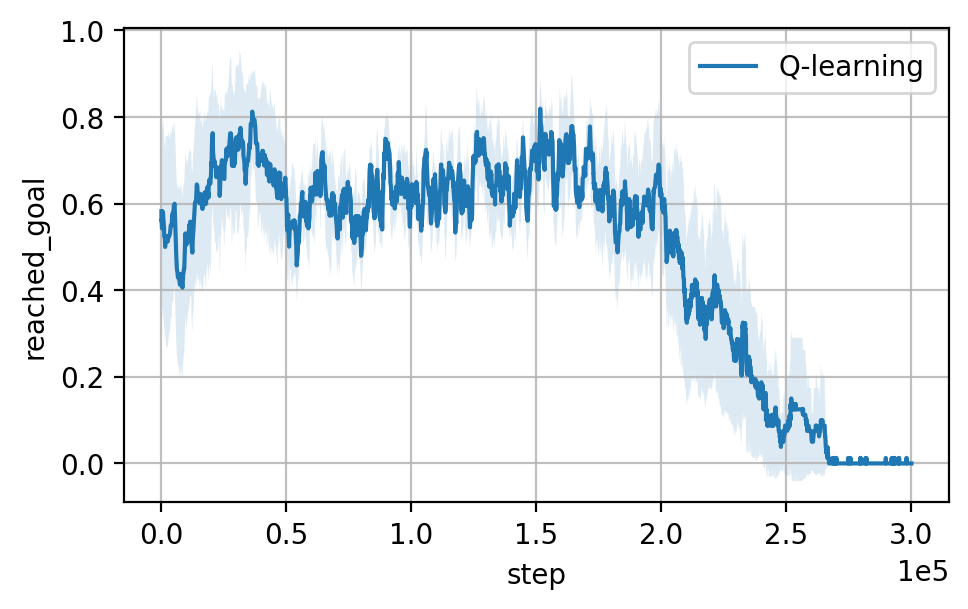

In [1066]:
print(log_dir)
key_name = "step"
# value_name = "reward"
# value_name = "maxQ"
value_name = "reached_goal"
# value_name = "len_episode"
x_label = key_name
y_label = value_name
label_name = algo_name
log_path = os.path.join(log_dir, "episodic.log")
save_path = os.path.join(log_dir, f"step-{value_name}")
# log_path = os.path.join('results/2rooms_steps30000_alphaQ0.1', "episodic.log")
plot_metric(log_path, key_name, value_name, x_label, y_label, label_name=label_name, interpolate=True, smooth=10, max_key=True, save_path=save_path)

# key_name = "step"
# # value_name = "maxQ"
# value_name = "reward"
# label_name = "VQ-learning1.0"
# log_path = os.path.join('results/2rooms_steps100000_raninit1_alphaV0.1_alphaQ1.0_eps0.3to0.00_decay0.9998_repeat10', "episodic.log")
# plot_metric(log_path, key_name, value_name, label_name=label_name, interpolate=True, smooth=10, max_key=True)

### Plot X from avg_meter.log

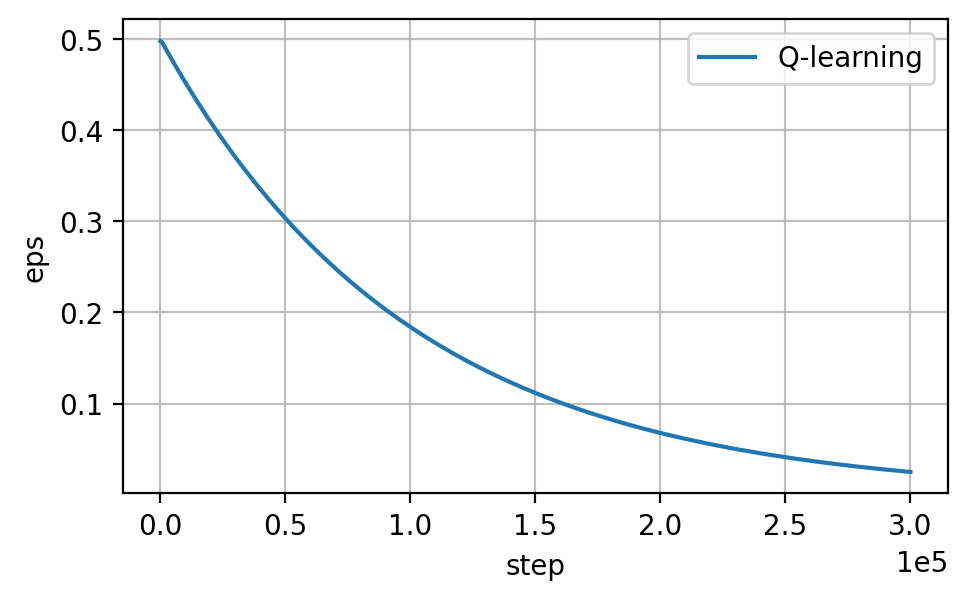

In [1041]:
key_name = "step"
# value_name = "Q(s,a)"
# value_name = "maxQ"
value_name = "eps"
# value_name = "temperature"
x_label = key_name
y_label = value_name
label_name = algo_name
# log_path = os.path.join(log_dir, "episodic.log")
log_path = os.path.join(log_dir, "avg_meter.log")
save_path = os.path.join(log_dir, f"step-{value_name}.png")

plot_metric(log_path, key_name, value_name, x_label, y_label, label_name=label_name, interpolate=True, smooth=10, max_key=True, save_path=save_path)

### Plot estimated Q and True Q

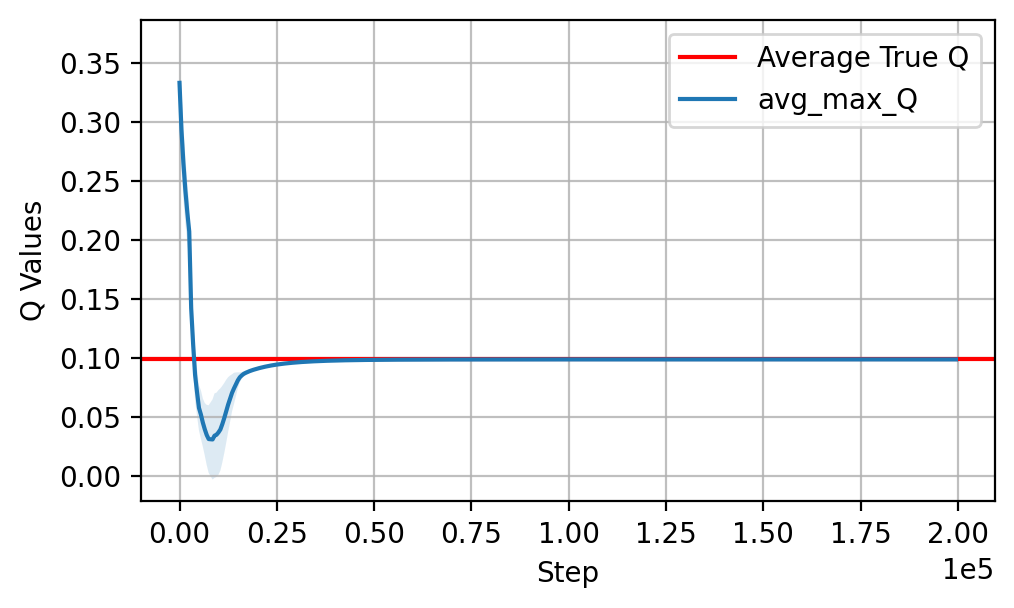

In [232]:
x_label = "Step"
y_label = 'Q Values'

key_name = "step"
# value_name = "Q(s,a)"
# value_name = "maxQ"
value_name = "avg_max_Q"
curve_name = value_name

log_path_true_return = os.path.join(log_dir, "true_return.log")
plot_avg_true_Q(log_path_true_return)

log_path = os.path.join(log_dir, "eval.log")
save_path = os.path.join(log_dir, "step-Q-TrueQ")

plot_metric(log_path, key_name, value_name, x_label, y_label, label_name=curve_name, interpolate=False, smooth=10, max_key=True, save_path=False)



### Plot V and Q

In [ ]:

x_label = "Step"
y_label = 'Values of V and Q'

key_name = "step"
value_name = "Q(s,a)"
# value_name = "maxQ"
curve_name = value_name

log_path = os.path.join(log_dir, "avg_meter.log")
save_path = os.path.join(log_dir, "step-V-Q")

plot_metric(log_path, key_name, value_name, x_label, y_label, label_name=curve_name, interpolate=False, smooth=10, max_key=True, save_path=False)
value_name = "V(s)"
curve_name = value_name
plot_metric(log_path, key_name, value_name, x_label, y_label, label_name=curve_name, interpolate=True, smooth=10, max_key=True, save_path=save_path)

# log_path_true_return = os.path.join(log_dir, "true_return.log")
# plot_avg_true_Q(log_path_true_return)



# log_path = os.path.join(log_dir, "avg_meter.log")
# x_label = "step"
# y_label = "Q(s,a)"
# plot_metric(log_path, x_label, y_label, label_name="Q(s,a)", interpolate=False)
# x_label = "step"
# y_label = "V(s)"
# plot_metric(log_path, x_label, y_label, label_name="V(s)", interpolate=False)

### Plot all runs

In [728]:
log_path

'results/2rooms_rwd0.1(-0.1,1)/SARSA/randinit1_explore[0.5,0.0,0.99995]_buffer1_1_is0.0_noisyV0.0_repeat15_steps100000--TrueQ/episodic.log'

1041 199998
928 199948
931 199941
835 199856
881 199925
1887 199998
6210 199998
879 199705


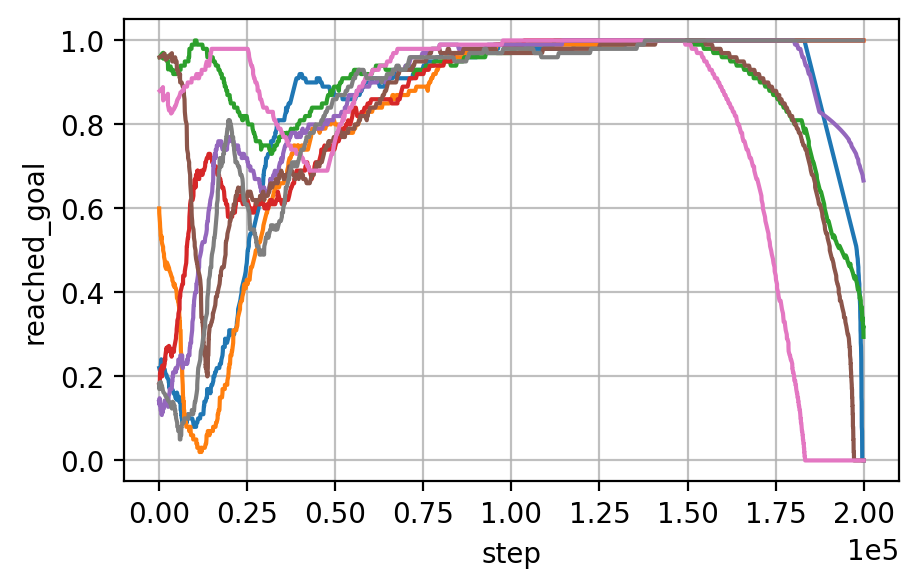

In [1050]:
# log_dir = "results/2rooms_steps100000_raninit1_alphaV0.1_alphaQ1.0_eps0.3to0.00_decay0.9998_repeat10"
# log_dir = "results/2rooms_rwd0.1/VQ-learning/randinit1_eps0.5to0.0_decay0.99995_buffer1_1_is0.0_syncVQ0_repeat20_steps200000"
# log_path = os.path.join(log_dir, "avg_meter.log")
log_path = os.path.join(log_dir, "episodic.log")
x_label = "step"
# y_label = "reward"
# y_label = "maxQ"
y_label = "reached_goal" 
# y_label = "len_episode"


save_path = os.path.join(log_dir, f"step-{y_label}-allruns")

smooth=100

last_idice = []
with open(log_path, "r") as f:
    last_repeat_idx = 0
    for line_idx, line in enumerate(f):
        data = json.loads(line)
        if data["repeat_idx"] != last_repeat_idx:
            last_idice.append(line_idx-1)
            last_repeat_idx = data["repeat_idx"]

if line_idx != last_idice[-1]:
    last_idice.append(line_idx)
last_idice = np.array(last_idice)
# for i in range(n_repeat):
#     # count number of lines for repeat i
#     n_lines = 0
#     with open(log_path, "r") as f:
#         for line in f:
#             data = json.loads(line)
#             if data["repeat_idx"] == i:
#                 n_lines += 1
#     last_idice.append(n_lines)
# last_idice = np.array(last_idice)
# # each element is the sum of the previous elements
# last_idice = np.cumsum(last_idice)
# last_idice = last_idice - 1

keys = []
values = []

with open(log_path, "r") as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        if x_label in data and y_label in data:
            keys.append(data[x_label])
            values.append(data[y_label])        
        if i in last_idice:
            keys, values = np.array(keys), np.array(values)
            print(len(keys), keys[-1])
            if smooth > 1 and values.shape[0] > 0:
                K = np.ones(smooth)
                ones = np.ones(values.shape[0])
                values = np.convolve(values, K, "same") / np.convolve(ones, K, "same")
            # plot data
            plt.plot(keys, values, label=f"rep_idx: {np.where(last_idice==i)[0][0]}")

            keys = []
            values = []


            
plt.rcParams["figure.figsize"] = (5, 3)
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.size"] = 10
plt.grid(alpha=0.8)
# plt.ylim(top=2.0)
# plt.legend(ncol=1)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
# save the plot to save_path
plt.savefig(f"{save_path}.png")
# plt.close()

### Compare algos

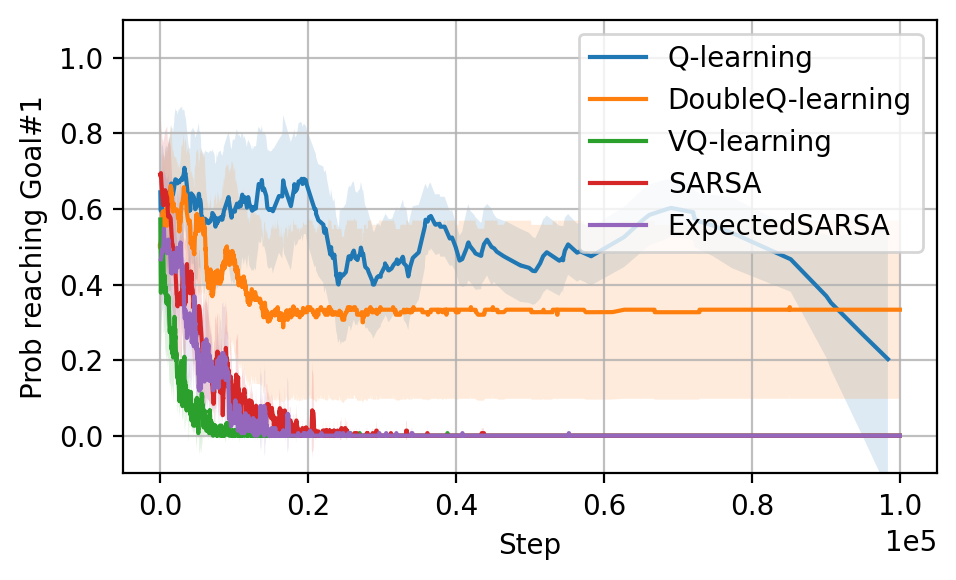

In [304]:
# mode = "episodic" 
# mode = "avg_meter"
# [version 1]:
# log_dir1 = "results/2rooms_randinit0_eps0.3to0.0_decay0.9998_buffer1_1_is0.0_syncVQ0_repeat5_steps30000"
# log_dir2 = "results/2rooms_randinit0_eps0.3to0.0_decay0.9998_buffer1_1_is0.0_syncVQ0_repeat5_steps30000_QLearning"
# log_dir3 = "results/2rooms_randinit0_eps0.3to0.0_decay0.9998_buffer1_1_is0.0_syncVQ0_repeat5_steps30000_DoubleQLearning"

# if mode == "episodic":
#     log_path1 = os.path.join(log_dir1, "episodic.log")
#     log_path2 = os.path.join(log_dir2, "episodic.log")
# else:
#     log_path1 = os.path.join(log_dir1, "avg_meter.log")
#     log_path2 = os.path.join(log_dir2, "avg_meter.log")
# save_path1 = os.path.join(log_dir1, "step-reward-compare-algos.png")
# save_path2 = os.path.join(log_dir2, "step-reward-compare-algos.png")
# print(log_path1)
# curve_name1 = "VQ-learning"
# curve_name2 = "Q-learning"
# key_name = x_label = "step"
# value_name = y_label = "reward"
# smooth=10


# plot_metric(log_path1, key_name, value_name, x_label, y_label, label_name=curve_name1, interpolate=True, smooth=10, max_key=True, save_path=False)
# plot_metric(log_path2, key_name, value_name, x_label, y_label, label_name=curve_name2, interpolate=True, smooth=10, max_key=True, save_path=save_path1)

# [version 2]:
# log_dirs = {
#     # "Q-learning" : "results/2rooms_randinit0_eps0.3to0.0_decay0.9998_buffer1_1_is0.0_syncVQ0_repeat5_steps30000_QLearning",
#     "Q-learning": "results/2rooms/Q-learning/randinit1_eps0.3to0.0_decay0.99995_buffer1_1_is0.0_syncVQ0_repeat10_steps60000",
#     # "DoubleQ-learning" : 'results/2rooms/DoubleQ-learning/randinit1_eps0.3to0.0_decay0.99995_buffer1_1_is0.0_syncVQ0_repeat10_steps30000',
#     "DoubleQ-learning": "results/2rooms/DoubleQ-learning/randinit1_eps0.3to0.0_decay0.99995_buffer1_1_is0.0_syncVQ0_repeat10_steps60000",
#     # "VQ-learning" : "results/2rooms_randinit0_eps0.3to0.0_decay0.9998_buffer1_1_is0.0_syncVQ0_repeat5_steps30000",
#     "VQ-learning": 'results/2rooms/VQ-learning/randinit1_eps0.3to0.0_decay0.99995_buffer1_1_is0.0_syncVQ0_repeat10_steps60000'
# }
# log_dirs = {
#     "Q-learning": 'results/2rooms/Q-learning/randinit1_eps0.3to0.0_decay0.9999_buffer1_1_is0.0_syncVQ0_repeat20_steps60000',
#     "DoubleQ-learning": 'results/2rooms/DoubleQ-learning/randinit1_eps0.3to0.0_decay0.9999_buffer1_1_is0.0_syncVQ0_repeat20_steps60000',
#     "VQ-learning": 'results/2rooms/VQ-learning/randinit1_eps0.3to0.0_decay0.9999_buffer1_1_is0.0_syncVQ0_repeat20_steps60000'
# }

algos = [
    "Q-learning", 
    "DoubleQ-learning", 
    "VQ-learning", 
    "SARSA", 
    "ExpectedSARSA"
]
# dirs = [
#     'randinit1_eps0.5to0.0_decay0.99995_buffer1_1_is0.0_syncVQ0_repeat20_steps200000',
#     'randinit1_eps0.5to0.0_decay0.99995_buffer1_1_is0.0_syncVQ0_repeat20_steps200000',  
#     'randinit1_eps0.5to0.0_decay0.99995_buffer1_1_is0.0_syncVQ0_repeat20_steps200000',    
# ]
dirs = [
    'randinit1_eps0.5to0.0_decay0.99995_buffer1_1_is0.0_syncVQ0_repeat15_steps100000--TrueQ',
    'randinit1_eps0.5to0.0_decay0.99995_buffer1_1_is0.0_syncVQ0_repeat15_steps100000--TrueQ',  
    'randinit1_eps0.5to0.0_decay0.99995_buffer1_1_is0.0_syncVQ0_repeat15_steps100000--TrueQ',    
    'randinit1_eps0.5to0.0_decay0.99995_buffer1_1_is0.0_syncVQ0_repeat15_steps100000--TrueQ',
    'randinit1_eps0.5to0.0_decay0.99995_buffer1_1_is0.0_syncVQ0_repeat15_steps100000--TrueQ',
]
file_name = "episodic.log"
# file_name = "avg_meter.log"
# file_name = "eval.log"
key_name = "step"
x_label = "Step"
# value_name = y_label = "reward"
value_name = "reached_goal"
# value_name = "avg_max_Q"
y_label = "Prob reaching Goal#1"

log_dirs = {}
for algo, dir in zip(algos, dirs):
    log_dirs[algo] = f"results/2rooms_rwd0.1(-0.1,2)/{algo}/{dir}"
for i, (key, value) in enumerate(log_dirs.items()):
    log_path = os.path.join(value, file_name)

    # value_name = y_label = "Q(s,a)"
    curve_name = key
    # save_path = os.path.join(value, f"step-{value_name}-acrossAlgos.png")

    # if i == len(log_dirs) - 1:
    #     plot_metric(log_path, key_name, value_name, x_label, y_label, label_name=curve_name, interpolate=True, smooth=10, max_key=True, save_path=save_path)
    # else:
    plot_metric(log_path, key_name, value_name, x_label, y_label, label_name=curve_name, interpolate=True, smooth=10, max_key=True, save_path=False)

plt.ylim(-0.1, 1.1)
plt.legend(loc="upper right", ncol=1)

save_dir = os.path.join("results/2rooms_rwd0.1/compareAlgos/", dirs[-1]+"")
save_path = os.path.join(save_dir, f"step-{value_name}-acrossAlgos")
# create save_dir if not exists 
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
if save_path:
    plt.savefig(f"{save_path}")


# log_dir = "results/2rooms_randinit0_eps0.3to0.0_decay0.9998_buffer1_1_is0.0_syncVQ0_repeat5_steps30000"
# key_name = "step"
# value_name = "reward"
# # value_name = "maxQ"
# x_label = key_name
# y_label = value_name
# label_name = algo_name
# log_path = os.path.join(log_dir, "episodic.log")
# print(log_path)
# save_path = os.path.join(log_dir, "step-reward.png")
# # log_path = os.path.join('results/2rooms_steps30000_alphaQ0.1', "episodic.log")
# plot_metric(log_path, key_name, value_name, x_label, y_label, label_name=label_name, interpolate=True, smooth=10, max_key=True, save_path=False)